En donnant à l’experte deux fichiers Excel (*videos\_pertinentes.xlsx* et *videos\_non\_pertinentes.xlsx*), elle a coloré les cellules correspondant à :

* **Faux négatifs** : vidéos réellement pertinentes mais prédites comme non pertinentes
* **Faux positifs** : vidéos réellement non pertinentes mais prédites comme pertinentes


In [1]:
from collections import Counter
from tqdm import tqdm 
from colorama import Style,Fore
import os
from utils1 import openJson,saveJson
from dotenv import load_dotenv
import json
import time
load_dotenv()

True

# Faux négatifs

## Collecter 

- En utilisant les cellules colorées par l'experte dans le fichier Excel

In [2]:
from openpyxl import load_workbook

# Charger le fichier Excel
wb = load_workbook("../xlsx/videos_non_pertinentes_RE.xlsx")
ws = wb.active

FN_video_Ids = []

for row in ws.iter_rows(min_col=1, max_col=1):
    cell = row[0]
    fill = cell.fill

    if fill and fill.fill_type == "solid":
        color = fill.start_color.rgb
        if color and color != "00000000":
            url = cell.value
            if isinstance(url, str) and "v=" in url:
                video_id = url.split("v=")[-1].split("&")[0]
                FN_video_Ids.append(video_id)

print("Liste des IDs des Faux négatifs :")
print(FN_video_Ids)
print(len(FN_video_Ids))

Liste des IDs des Faux négatifs :
['Yb-ujblpLDQ', 'Yc24O1r7FfU', 'jCFsMCbpeQU', 'bTPs8Q5XWqI', 'iaUboIY9X4Q', 'bxKPfPnSdK0', 'UcRpcyK61lg', 'VqM9iY_VnYw', '59tr5CwIo2k', '4LcZpws5NXs', 'dlE9z6o98tU', 'JXM37dFVa3Y', 'Q6LBWZUyD7k', '_eH4_L_4h6U', 'kfgdbexwdvQ', '78HJs4s0UGw', 'hOTW7F_ANj8', 'FDMUxduCG-E', 'RqIHYrth0K0', 'kGz8wybwLXI', 'oMazIgjhJc0', 'SvPDihkf9Ok', 'nN-4vukYGEY', 'IQDS8x3RoU0', 'A5NXVOS9FrE', 'DD2vJ1U9Idw', 'teUj6GeJ93A', '4ctTmvq3JvY', 'hdLuhejUKeU', 'xvMKW0Nlonc', 'DdzpreePx6Q', 'MAdOsBjGhiE', 'QxBEtwqNk34', 'ViczdDgcTDw', 'Y_MshcXrnj8', '0SJIW9GnaMY', 'e6AB7GKctN4', 'BfCIvl4VjbQ', 'LPobB6_IE1s', '6PoH5j_CJxc', 'd06ssNOndOk', '7S0fANnj5bY', 'aa4j72ncF4c', 'dolrcneBWlI', '1XQalJkN2iM', 'RLM7W6eHKfM', '2JffEu5fPLw', '80HSWRSk24M', '396LC6lbtZQ', 'j19l2Fgg81A', 'Oa_8LgMIm8I', 'o7jKR1jjlsA']
52


## Analyser

In [ ]:
# Les vidéos prédites comme non pertinentes

videosF3Non = openJson("../jsons/videosF3Non.json")
len(videosF3Non)

In [ ]:
scores = []
for video in videosF3Non:
    if video['id_video'] in FN_video_Ids:
        scores.append(video['score'])
        
Counter(scores)

**50** ont un score LLM de 6 ou 7 (c’est comme une frontière de décision pour le LLM).

**Ajustement de system prompt :**

- Attribuer un score (float) de 1 à 10 pour évaluer la pertinence de la vidéo par rapport à la thématique de l'autosuffisance.
- Donner un score plus élevé pour les vidéos qui mentionnent explicitement des mots-clés liés à cette thématique.


# Faux positifs

## Collecter

- En utilisant les cellules colorées par l'experte dans le fichier Excel

In [3]:
from openpyxl import load_workbook

wb = load_workbook("../xlsx/videos_pertinentes_RE.xlsx")
ws = wb.active

FP_dict = {}

for row in ws.iter_rows(min_row=2, min_col=1, max_col=3):
    fp_type_cell = row[0]
    lien_cell = row[1]

    fill = lien_cell.fill

    if fill and fill.fill_type == "solid":
        color = lien_cell.fill.start_color.rgb
        if color and color != "00000000":
            url = lien_cell.value
            if isinstance(url, str) and "v=" in url:
                video_id = url.split("v=")[-1].split("&")[0]
                fp_type = fp_type_cell.value
                FP_dict[video_id] = fp_type

print("Dictionnaire des vidéos colorées avec leur FP_type :")
print(FP_dict)
print (len(FP_dict))


Dictionnaire des vidéos colorées avec leur FP_type :
{'LXoDDQ_GpiA': 'A', 'kUIPnI6fBCU': 'A', 'hAgGD_YiFlA': 'EP', 'ZFfc0R9IiZU': 'A', 'x0vRWEFKlb8': 'M', 'bIMjariydVA': 'A', 'NzoaJgzKWIU': 'A', 'EWNjhLPss8o': 'EP', 'heOuHHI_C4I': 'H', '5iNpvA7uwg4': 'D', 'ebwA9efjDyg': 'A', 'S-YEu_UJiio': 'D', '70phFq2MnD4': 'D', 'Kg_moYtLH0Q': 'H', 'B_-g9Pp2bBQ': 'A', 'sgm_zU_W5jc': 'H', 'hdeJUcDYTqY': 'M', 'bLoHGlpQdaU': 'M', 'eKudrSrjwFM': 'EP', 'MOSzLYnA_14': 'EP', 'TOPIXbkj70k': 'H', 'aDbbH734ThA': 'EP', 'VgUVzkHVc7I': 'EP', '2U5jfAsuV18': 'H', 'aOza7UCfi1o': 'H', '3OXbnQutAt0': 'D', 'NtC_xg3vYWg': 'D', 'AYYl7SuXbS0': 'D', 'oQ-EeHQAo58': 'D', 'nSXLLml9OJc': 'D', 'N0cVC5zO-aE': 'D', '9AHEkShwi5Y': 'H', 'jH-VSZSc8-Y': 'D', 'CbJQZwDEqU4': 'D', 'XeJWoVSBhNA': 'D', 'fMCtESAAMuc': 'D', 'cbaiO5-q0mI': 'D', '8_f6RxY93EA': 'D', '9_OgldCDNvY': 'D', 'V4GQ5dcUHis': 'M', 'MbnrZ8rB1oI': 'D', 'VZt9NBqKZHY': 'A', '8SW7OsOWlRY': 'H', '6hfS2VhRzqQ': 'A', 'qppDyOgwygI': 'A', '3P3Cm8gyOsg': 'D', 'SOweVg7cFUE': 'D'}


## Analyser

In [ ]:
# Les vidéos prédites comme non pertinentes

videosF3 = openJson("../jsons/videosF3.json")
len(videosF3)

In [ ]:
scores = []
for video in videosF3:
    if video['id_video'] in FP_dict.keys():
        scores.append(video['score'])
        
Counter(scores)

**12** ont un score LLM de 7.


- Autre que la France (A)
- Médias (M)
- Entreprises-pubs (EP)
- Difficile (D)
- Hors sujet (H)

**Ajustement de prompt**

Les vidéos suivants doivent être exclus, même s’ils parlent d’autosuffisance ou sont liés à la thématique :

- Les vidéos provenant d'une chaîne TV ou radio.
- Les vidéos concernant un emplacement hors de la France.
- Les vidéos d'entreprises commercialisant des produits ou des vidéos publicitaires.
- Les vidéos hors sujet telles que les webinaires, webconférences, ou présentations commerciales.


# Préparer un JSON

In [9]:
videosF2 = openJson('../jsons/videosF2.json')
len(videosF2)

4504

In [10]:
def getVideo(ID):
    for video in videosF2:
        if video['id_video']==ID:
            return video

In [ ]:
retourExperte = []

for FNid in FN_video_Ids:
    FN_video = getVideo(FNid)
    FN_video['groundTruth']='pertinente'
    retourExperte.append(FN_video)
        
saveJson('../jsons/retourExperte.json',retourExperte)
print(len(retourExperte))

In [ ]:
for FPid in FP_dict.keys():
    FP_video = getVideo(FPid)
    FP_video['groundTruth']='Non_pertinente'
    FP_video['FP_type']= FP_dict[FPid]
    retourExperte.append(FP_video)
        
saveJson('../jsons/retourExperte.json',retourExperte)
print(len(retourExperte))

# Tester le nouveau prompt

In [ ]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
gemini_flash_1 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_1"),temperature = 0.1)
gemini_flash_2 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_2"),temperature = 0.1)
gemini_flash_3 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_3"),temperature = 0.1)

In [ ]:
sysprompt = """
# La définition d’autosuffisance
---

L'autosuffisance est la démarche visant à acquérir la capacité de subvenir par soi-même à ses besoins fondamentaux, 
en premier lieu alimentaires par l'autoconsommation – c'est-à-dire produire, récolter et conserver un maximum de sa propre nourriture, 
souvent en privilégiant le bio, le local et le saisonnier. 

L'autosuffisance Plus qu'une simple recherche d'autonomie matérielle, elle représente un engagement pour être moins dépendant du système économique et social extérieur, impliquant des choix concrets comme trouver un lieu propice et le concevoir judicieusement (par exemple en permaculture), 
ainsi qu'un changement dans la manière de valoriser son temps et de consommer, formant ainsi le fondement d'une vie plus autonome.

---

# Votre mission
---

- Décider si une vidéo concerne la thématique de l'autosuffisance en se basant sur ses métadonnées (titre, description, tags).  

- Attribuer un score (float) de 1 à 10 pour évaluer la pertinence de la vidéo par rapport à la thématique de l'autosuffisance.

- Donner un score plus élevé pour les vidéos qui mentionnent explicitement des mots-clés liés à cette thématique.

# **Les vidéos non pertinentes (Répondre par non)**
---

Les vidéos suivants doivent être **exclus**, même s’ils parlent d’autosuffisance ou sont liés à la thématique :


- **Les vidéos provenant d'une chaîne TV ou radio**  
- **Les vidéos concernant un emplacement hors de la France** 
- **Les vidéos d'entreprises commercialisant des produits ou des vidéos publicitaires.**  
- **Les vidéos hors sujet**, telles que les webinaires, webconférences, ou présentations commerciales.

---

# **Les vidéos pertinentes (Répondre par oui)**
---

- Les vlogs, les interviews et les vidéos de partage d'expériences en lien avec l'autosuffisance sont intéressants.  
- Les tutoriels et les vidéos de conseils sont également pertinents.  
- Les vidéos présentant une technique trés liée à l'autosuffisance.  


# Votre réponse  
--- 

- La réponse doit être au format JSON :  

    "decision": "oui ou non",
    "justification": "Justifiez votre décision avec des arguments",
    "score": Votre évaluation en format décimal pour que ce soit plus précis.
"""

userprompt = """
Titre
---
{titre}
Description
---
{description}
tags
---
{tags}
"""

prompt = ChatPromptTemplate([
    ("system", sysprompt),
    ("user", userprompt)
])

chain_1 = prompt | gemini_flash_1
chain_2 = prompt | gemini_flash_2
chain_3 = prompt | gemini_flash_3

## Test

In [ ]:
input = {"titre":"Des solutions bon marché pour moderniser ses tracteurs !",
         "description":"Cette semaine, Jean-Paul Hébrard vous emmène à AgriMax ! L'occasion de discuter de l'autonomie des exploitations agricoles, mais aussi de découvrir quelques innovations étonnantes, comme un robot nettoyeur de panneaux photovoltaïques, ou des technolgies de guidage bons marchés et efficaces !\nEnjoy !\n\nS'abonner en 1 clic !\nhttps://www.youtube.com/channel/UCXur-8uR91-dEiafZevXwGQ/?sub_confirmation=1\n\nBonjour à toutes et à tous,\n\nPowerBoost est l’émission TV entièrement consacrée à l'agriculture !\n\nSi vous avez aimé cette émission n’hésitez pas à la partager, et à venir parler agriculture avec nous sur :\nInstagram : Powerboosttv\nFacebook : http://www.facebook.com/powerboosttv\nTwitter : https://twitter.com/Power_Boost\nSnapchat : Powerboosttv\n\nNos sites partenaires :\nhttp://www.agriculture-nt.com\nhttp://www.machinisme-actualites.com",
         "tags":', '.join( [
     
    ])}
print(input)
print(chain_3.invoke(input))

In [ ]:
input = {"titre":"Autonomie - 37 - Installation Nouvelle Pompe D'Arrosage",
         "description":"Pompe : FLUXE MC150\n1100W, 7200L/H, 4.9bars\n\n\nEt si, vous aussi, vous souhaitez participer, vous pouvez me soutenir via Tipeee : https://fr.tipeee.com/edenguard\nMerci ! ;)\n\nInfos sur mon site internet : http://www.edenguard.fr",
         "tags":', '.join( [
     
    ])}
print(input)
print(chain_3.invoke(input))

## Exécuter sur l'ensemble

In [ ]:
retourExperte = openJson('../jsons/retourExperte.json')
len(retourExperte)

In [ ]:
def cleanAnswer(answer):
    answer = answer.strip("`")   
    if answer.startswith("json"):
        answer = answer[4:].strip() 
    return  answer

In [ ]:
count1 = 0
count2 = 0
count3 = 0

for item in tqdm(retourExperte):
  
    input = {"titre":item['titre_video'],
             "description":item['description'],
             "tags":', '.join(item['tags']),}
    try:
        if count1  <= 13:
        
            answer = cleanAnswer(chain_1.invoke(input))
            answer = json.loads(answer)
            item.update(answer)
            
            count1+=1
            
        if count1  > 13 and count2 <= 13:
            
            answer = cleanAnswer(chain_2.invoke(input))
            answer = json.loads(answer)
            item.update(answer)
            
            count2+=1
 
        if  count1  > 13 and count2  > 13 and count3 <= 13:
           
            answer = cleanAnswer(chain_3.invoke(input))
            answer = json.loads(answer)
            item.update(answer)
            
            count3+=1
      
        if count1 > 13 and count2 > 13 and count3 > 13 :
            print("sleep for 50 s")
            time.sleep(50)
            count1 = 0
            count2 = 0
            count3 = 0
            
    except Exception as e:
        print(f"error {e}")
        
saveJson("../jsons/retourExperte.json",retourExperte)

In [ ]:
for item in retourExperte:
    
    if item['decision'] == 'non' and item['score'] <3:
        item['prédiction']='Non_pertinente'
    else :
        
        ip = 0.5*( len(item['requete'])  + item['score'])
        item['IP'] = ip
        if ip > 4 :
            item['prédiction']='pertinente'
        else :
            item['prédiction']='Non_pertinente'

saveJson("../jsons/retourExperte.json",retourExperte)

## Calculer les métriques d’évaluation


In [ ]:
def getEvaluationMetrics(TP,TN,FP,FN):
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f"Accuracy : {accuracy:.2%}")
    print(f"F1-score : {f1_score:.2%}")
    #return round(accuracy,2),round(f1_score,2)

def getMetrics():
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for video in retourExperte:
        if video['groundTruth'] == 'pertinente':
            if video['prédiction'] == 'pertinente':
                TP+=1
            else :
                FN +=1
                
        if video['groundTruth'] == 'Non_pertinente':
            if video['prédiction'] == 'Non_pertinente':
                TN+=1
            else :
                FP +=1 
                   
    getEvaluationMetrics(TP,TN,FP,FN)           


In [ ]:
retourExperte = openJson('../jsons/retourExperte.json')
len(retourExperte)

In [ ]:
getMetrics()

# Rectifier les résultats de filtrage

- On va passer les faux négatifs au fichier des vidéos pertinentes et les faux positifs au fichier des vidéos non pertinentes.


In [21]:
videosF3 = openJson('../jsons/videosF3.json')
videosF3Non = openJson('../jsons/videosF3Non.json')

print(len(videosF3))
print(len(videosF3Non))

3104
1499


In [17]:
for id in FN_video_Ids:
    video = getVideo(id)
    videosF3.append(video)

saveJson('../jsons/videosF3.json',videosF3)
len(videosF3)


 json saved


3104

In [18]:
for id in FP_dict.keys():
    video = getVideo(id)
    videosF3Non.append(video)

saveJson('../jsons/videosF3Non.json',videosF3Non)
len(videosF3Non)


 json saved


1499

## Visualisation des résultats

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


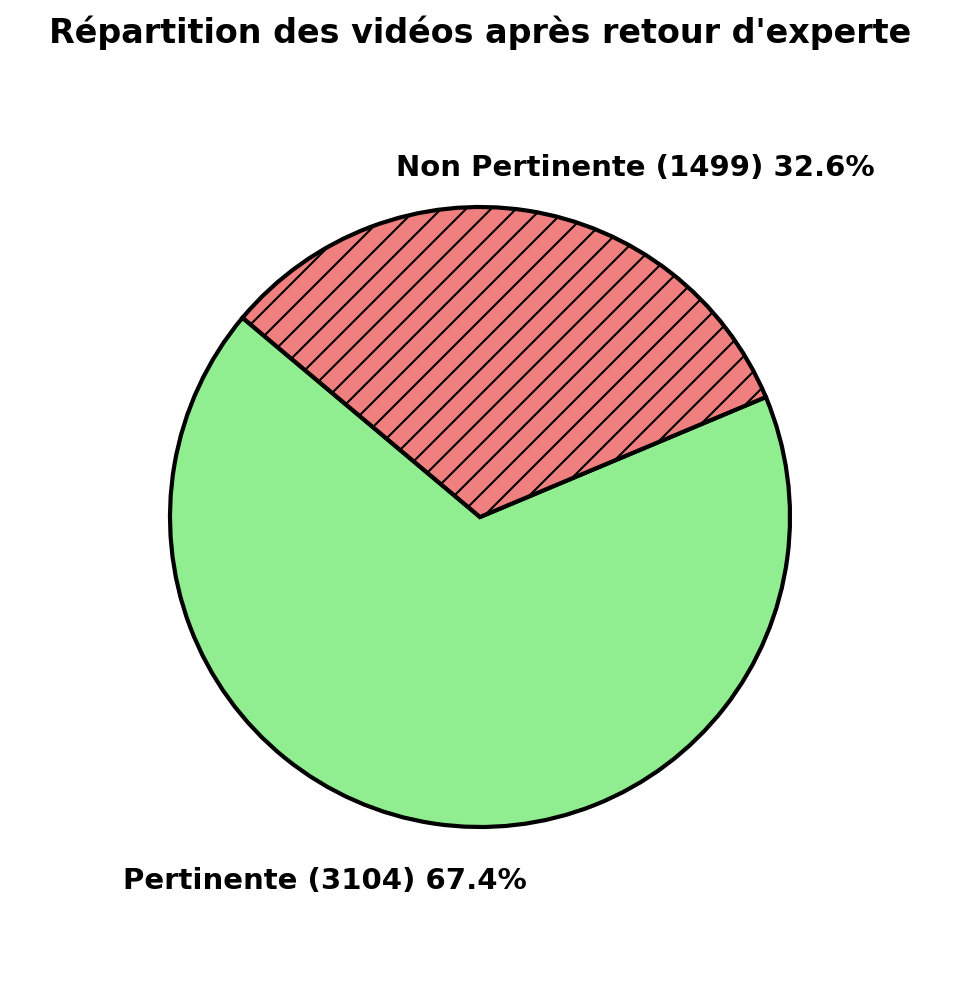

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

sizes = [3104, 1499]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)

angle_start = 140
angle_non = angle_start + (sizes[0] / sum(sizes)) * 360

fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

w1 = Wedge(center=(0, 0), r=1, theta1=angle_start, theta2=angle_non,
           facecolor='lightgreen', edgecolor='black', lw=2, zorder=5)
w2 = Wedge(center=(0, 0), r=1, theta1=angle_non, theta2=angle_start + 360,
           facecolor='lightcoral', edgecolor='black', hatch='//', lw=2, zorder=5)

ax.add_patch(w1)
ax.add_patch(w2)

ax.text(-0.5, -1.2, f'Pertinente ({sizes[0]}) {sizes[0]/sum(sizes)*100:.1f}%', fontsize=14, ha='center', fontweight='bold', zorder=10)
ax.text(0.5, 1.1, f'Non Pertinente ({sizes[1]}) {sizes[1]/sum(sizes)*100:.1f}%', fontsize=14, ha='center', fontweight='bold', zorder=10)

ax.set_title("Répartition des vidéos après retour d'experte", fontsize=16, fontweight='bold')

ax.axis('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

plt.show()
